# Amazon Review Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

In [2]:
stemmer = nltk.SnowballStemmer("english")
stopword=set(stopwords.words('english'))

In [3]:
# seeding random number generator
np.random.seed(2024)

In [4]:
raw = pd.read_csv('./dataset/amazon-review.csv')
raw.head(3)

,id,name,asins,brand,categories,keys,manufacturer,reviews.date,reviews.dateAdded,reviews.dateSeen,...,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,This product so far has not disappointed. My c...,Kindle,NaN,NaN,Adapter
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,great for beginner or experienced person. Boug...,very fast,NaN,NaN,truman
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...",B01AHB9CN2,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...","841667104676,amazon/53004484,amazon/b01ahb9cn2...",Amazon,2017-01-13T00:00:00.000Z,2017-07-03T23:33:15Z,"2017-06-07T09:04:00.000Z,2017-04-30T00:45:00.000Z",...,True,NaN,0.0,5.0,http://reviews.bestbuy.com/3545/5620406/review...,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,NaN,DaveZ


In [5]:
data = raw.copy()
data.describe()

,reviews.id,reviews.numHelpful,reviews.rating,reviews.userCity,reviews.userProvince
count,1.0,34131.000000,34627.000000,0.0,0.0
mean,111372787.0,0.630248,4.584573,NaN,NaN
std,NaN,13.215775,0.735653,NaN,NaN
min,111372787.0,0.000000,1.000000,NaN,NaN
25%,111372787.0,0.000000,4.000000,NaN,NaN
50%,111372787.0,0.000000,5.000000,NaN,NaN
75%,111372787.0,0.000000,5.000000,NaN,NaN
max,111372787.0,814.000000,5.000000,NaN,NaN


In [6]:
def check_df(dataframe, head=5):
    print("-----Shape-----")
    print(dataframe.shape)
    print("----- Types -----")
    print(dataframe.dtypes)
    print("----- Head -----")
    print(dataframe.head(head))
    print("----- Null -----")
    print(dataframe.isnull().sum())

check_df(data)

-----Shape-----
(34660, 21)
----- Types -----
id                       object
name                     object
asins                    object
brand                    object
categories               object
keys                     object
manufacturer             object
reviews.date             object
reviews.dateAdded        object
reviews.dateSeen         object
reviews.didPurchase      object
reviews.doRecommend      object
reviews.id              float64
reviews.numHelpful      float64
reviews.rating          float64
reviews.sourceURLs       object
reviews.text             object
reviews.title            object
reviews.userCity        float64
reviews.userProvince    float64
reviews.username         object
dtype: object
----- Head -----
                     id                                               name  \
0  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
1  AVqkIhwDv8e3D1O-lebb  All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...   
2  AVqkIhwDv8e3D1

In [7]:
data = data.dropna(subset=["reviews.rating"])
data = data.dropna(subset=["reviews.text"])

In [8]:
data.isnull().sum()

id                          0
name                     6759
asins                       2
brand                       0
categories                  0
keys                        0
manufacturer                0
reviews.date               29
reviews.dateAdded       10587
reviews.dateSeen            0
reviews.didPurchase     34625
reviews.doRecommend       560
reviews.id              34625
reviews.numHelpful        495
reviews.rating              0
reviews.sourceURLs          0
reviews.text                0
reviews.title               5
reviews.userCity        34626
reviews.userProvince    34626
reviews.username            2
dtype: int64

## Review and Sentiment Analysis

In [9]:
review=pd.concat([data['reviews.text'],data['reviews.rating']], axis=1)
review.head()

,reviews.text,reviews.rating
0,This product so far has not disappointed. My c...,5.0
1,great for beginner or experienced person. Boug...,5.0
2,Inexpensive tablet for him to use and learn on...,5.0
3,I've had my Fire HD 8 two weeks now and I love...,4.0
4,I bought this for my grand daughter when she c...,5.0


In [10]:
review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34626 entries, 0 to 34659
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviews.text    34626 non-null  object 
 1   reviews.rating  34626 non-null  float64
dtypes: float64(1), object(1)
memory usage: 811.5+ KB


In [11]:
review['reviews.rating'].value_counts()

5.0    23774
4.0     8541
3.0     1499
1.0      410
2.0      402
Name: reviews.rating, dtype: int64

In [12]:
# Map ratings 1-2 as negative, 3 as neutral, and 4-5 as positive

sentiment_score = {1: 0,
                   2: 0,
                   3: 1,
                   4: 2,
                   5: 2}

sentiment = {0: 'Negative',
             1: 'Neutral',
             2: 'Positive'}

review['sentiment_score'] = review['reviews.rating'].map(sentiment_score)
review['sentiment'] = review['sentiment_score'].map(sentiment)

review.head()

,reviews.text,reviews.rating,sentiment_score,sentiment
0,This product so far has not disappointed. My c...,5.0,2,Positive
1,great for beginner or experienced person. Boug...,5.0,2,Positive
2,Inexpensive tablet for him to use and learn on...,5.0,2,Positive
3,I've had my Fire HD 8 two weeks now and I love...,4.0,2,Positive
4,I bought this for my grand daughter when she c...,5.0,2,Positive


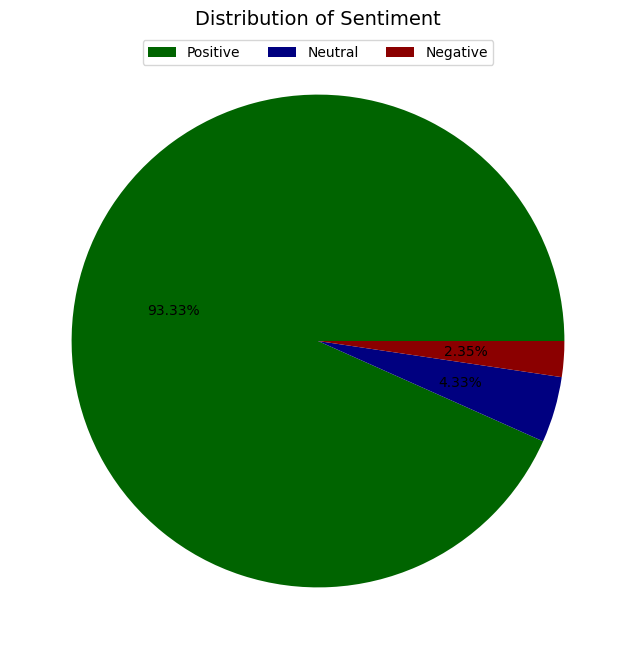

In [13]:
plt.figure(figsize = (8, 8))

labels = ['Positive', 'Neutral', 'Negative']
colors = ['darkgreen', 'navy', 'darkred']
plt.pie(review['sentiment'].value_counts(), autopct='%0.2f%%',colors=colors)

plt.title('Distribution of Sentiment', size=14)
plt.legend(labels, ncol=3, loc=9)
plt.show()

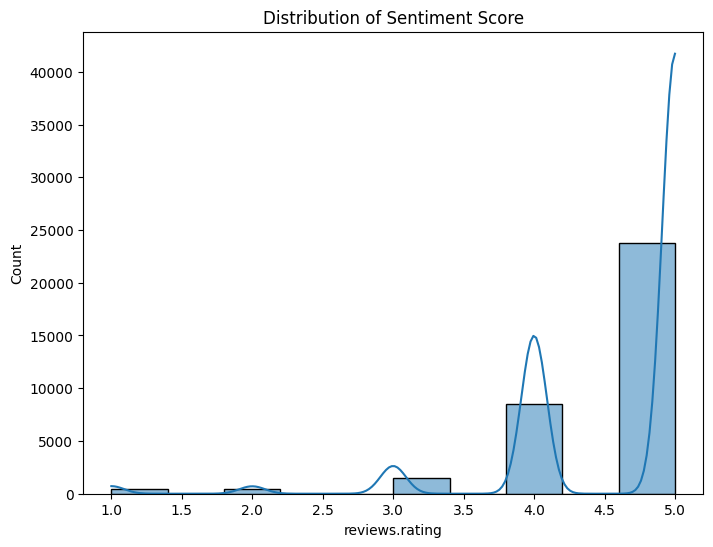

In [14]:
plt.figure(figsize=(8, 6))

sns.histplot(review['reviews.rating'], bins=10, kde=True)
plt.title('Distribution of Sentiment Score')
plt.ylabel=('Count')
plt.xlabel=('Reviews Rating')
plt.show()

In [15]:
words = pd.Series(' '.join(str(review['reviews.text']).split()))

In [16]:
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

In [17]:
stopword_list = stopwords.words('english')
suitable_stopwords=[]
l =["n'",'nor','no','not']
for i in stopword_list:
    if not any(words in i for words in l):
        suitable_stopwords.append(i)

In [18]:
suitable_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
replace_list=['ain','aren', 'hate', 'bad', 'worse', 'worst', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'mightn', 'mustn', 'needn',
              'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn',"n't","n'"]

In [20]:
def cleanstr(text):
    text=text.lower()
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(' \d+', ' ', text)
    return text

In [21]:
def remove_stopwords(stmt):
    filtered_sentence = []
    stmt=stmt.lower()
    words = word_tokenize(stmt)
    
    for w in words:
        if w not in suitable_stopwords:
            if w not in replace_list:
                filtered_sentence.append(w)
            else:
                filtered_sentence.append(w+' not')
    return " ".join(filtered_sentence)

In [22]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [23]:
def lemmatize(text):
    wl = WordNetLemmatizer()
    lemmatized_sentence = []
    # Tokenize the sentence
    words = word_tokenize(text)
    word_pos_tags = nltk.pos_tag(words)
    for idx, tag in enumerate(word_pos_tags):
        lemmatized_sentence.append(wl.lemmatize(tag[0], get_wordnet_pos(tag[1])))

    return " ".join(lemmatized_sentence)

In [24]:
review['text']=review['reviews.text'].apply(cleanstr)
review['text']=review['text'].apply(remove_stopwords)
review['text']=review['text'].apply(lemmatize)
review['text'].iloc[0]

'product far not disappointed child love use like ability monitor control content see ease'

In [25]:
positive = review[review['sentiment_score'] == 2]
neutral = review[review['sentiment_score'] == 1]
negative = review[review['sentiment_score'] == 0]

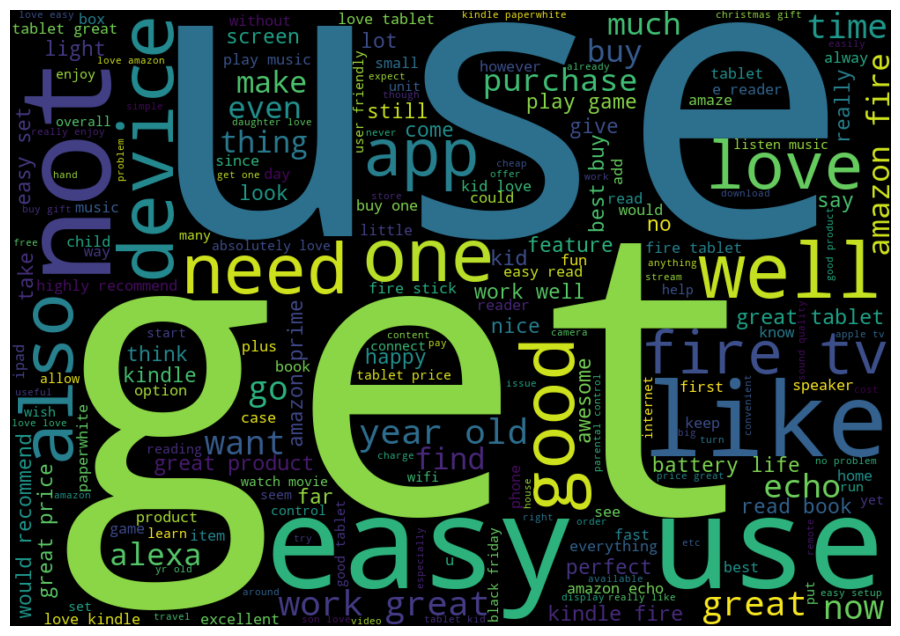

In [26]:
pos = " ".join(review for review in positive.text)
wordcloud = WordCloud(width=1000, height = 700, stopwords=suitable_stopwords).generate(pos)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

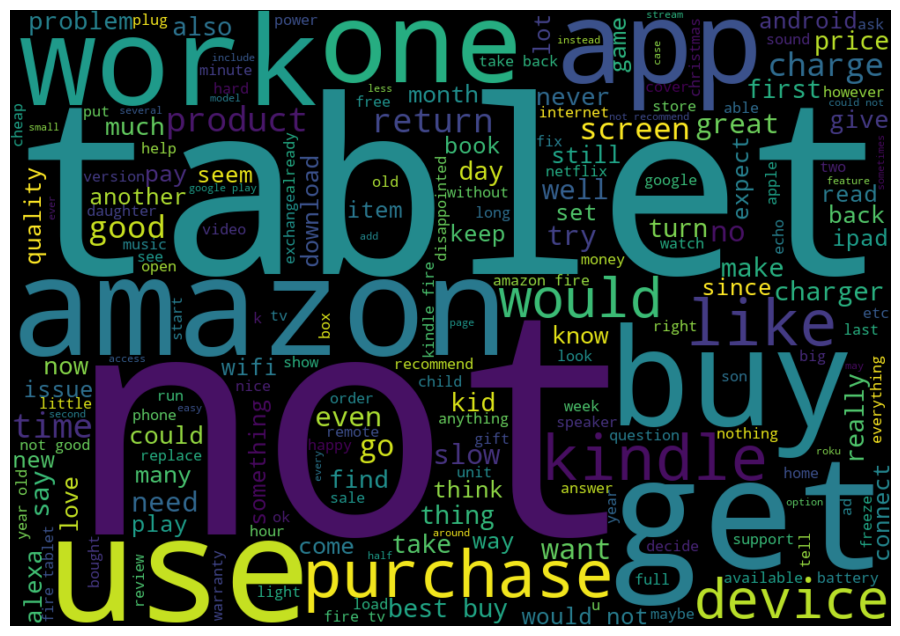

In [27]:
neg = " ".join(review for review in negative.text)
wordcloud2 = WordCloud(width=1000, height = 700, stopwords=replace_list).generate(neg)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

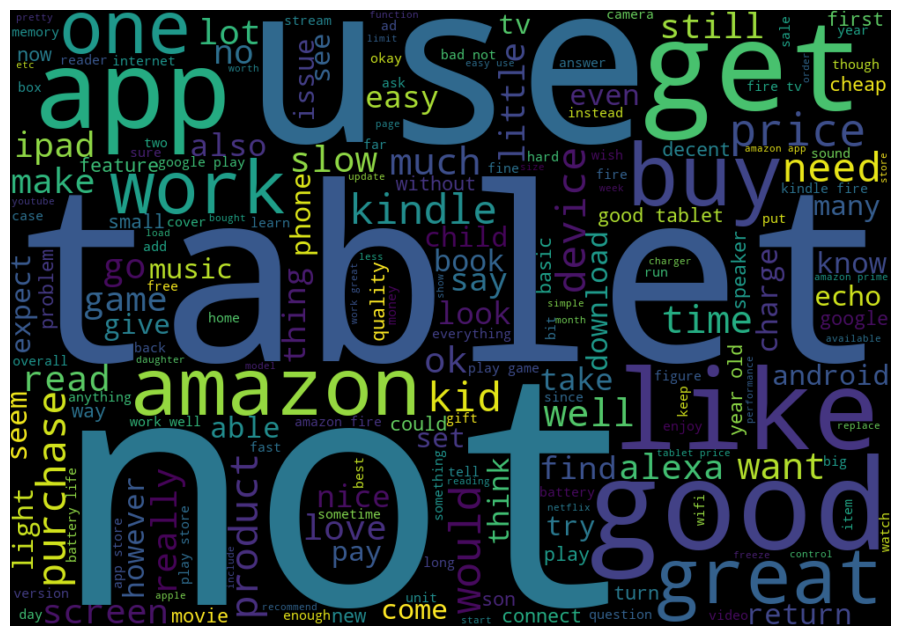

In [28]:
neu = " ".join(review for review in neutral.text)
wordcloud3 = WordCloud(width=1000, height = 700, stopwords=suitable_stopwords).generate(neu)
plt.figure(figsize=(16,8))
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

## Review Prediction

In [29]:
split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(review,
                                           review["reviews.rating"]): 
    strat_train = review.reindex(train_index)
    strat_test = review.reindex(test_index)

In [30]:
strat_train['reviews.text'].fillna('', inplace=True)
strat_test['reviews.text'].fillna('', inplace=True)

strat_train['sentiment_score'].fillna(1.0, inplace=True)
strat_test['sentiment_score'].fillna(1.0, inplace=True)

In [31]:
tfidf = TfidfVectorizer()
train_matrix = tfidf.fit_transform(strat_train['reviews.text'])
test_matrix = tfidf.transform(strat_test['reviews.text'])

In [32]:
# Logistic Regression
clf = LinearSVC()

In [33]:
X_train = train_matrix
X_test = test_matrix
y_train = strat_train['sentiment_score']
y_test = strat_test['sentiment_score']

In [34]:
set(y_train)

{0.0, 1.0, 2.0}

In [35]:
clf.fit(X_train,y_train)

LinearSVC()

In [36]:
predictions = clf.predict(X_test)

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

print(confusion_matrix(y_test, predictions))
print('\n')
print(classification_report(y_test, predictions))
clf.score(X_train, y_train)

[[  33    8  117]
 [  15   28  252]
 [  15   31 6427]]


              precision    recall  f1-score   support

         0.0       0.52      0.21      0.30       158
         1.0       0.42      0.09      0.15       295
         2.0       0.95      0.99      0.97      6473

    accuracy                           0.94      6926
   macro avg       0.63      0.43      0.47      6926
weighted avg       0.91      0.94      0.92      6926



0.9648375451263538

The overall accuracy is close to 96%

### Test

In [38]:
text="I hate the product. It's that bad."

text=cleanstr(text)
text=remove_stopwords(text)
text=(lemmatize(text))
print(text)

hate not product bad not


In [39]:
vec=tfidf.transform([text])
pre=clf.predict(vec)

if pre==0.0:
    print("Negative")
elif pre==1.0:
    print("Neutral")
else:
    print("Positive")

Negative
